In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'

In [4]:
import os

from PIL import Image
import numpy as np

from utils.fat_utils import Scene, Side
from utils import coor_utils, visualize, class_names, cv2_utils
from utils import data as datalib

from misc import fragment, uv_map

# Preparation

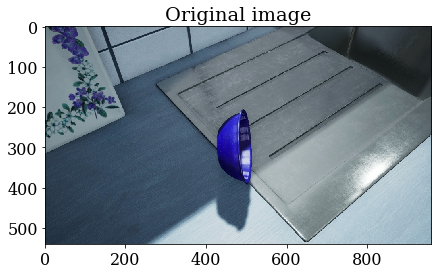

In [5]:
scene = Scene('./fat/single/024_bowl_16k/kitchen_0/', 0)
left = scene.left

img = Image.fromarray(scene.left.img.copy())
plt.imshow(img); plt.title("Original image"); plt.show()

model_root = './fat/ycb_models_nvdu_aligned_cm/024_bowl//google_512k/'
pts = datalib.load_obj(model_root+'textured.obj')

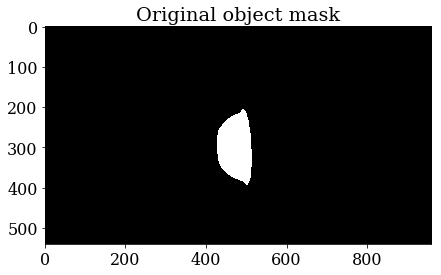

In [6]:
plt.imshow(left.seg); plt.title("Original object mask"); plt.show()

# UV Mapping

- Each pixel of object in 2D image is represented as U and V channel
- U and V are both in [0, 256) respectively
- For the last channel, we use 0, hence each pixel is (U, V, 0)

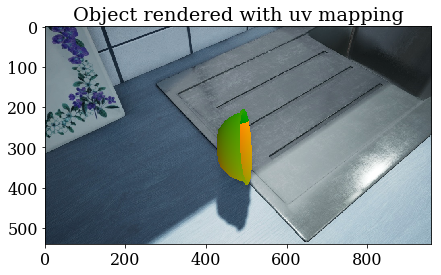

In [7]:
nbins = 256

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

pts_disp = pts[store_dict['depth_sorted_ind'], :]

uv_img_perfect = uv_map.draw_uv_map_image(
    pts_disp, pts_ind, scene.left.img, method='s', bins=nbins)
plt.imshow(uv_img_perfect); plt.title("Object rendered with uv mapping"); plt.show()

## Do PnP fitting

### Fits a *perfect* uv map, and there is no error between GT and estimation

number of valid points:  36318
Difference of Tmw_estimated and Tmw_true:
 [[ 0.00466259 -0.0012841  -0.00499667 -0.10845187]
 [ 0.00131594 -0.00028478 -0.00145144 -0.0196784 ]
 [ 0.00087093 -0.0067241   0.00250777  0.14173051]
 [ 0.          0.          0.          0.        ]]
L2 norm of difference:  0.269860783634317


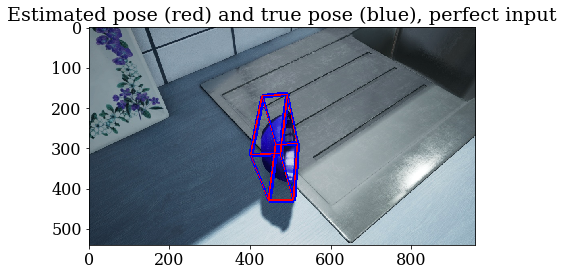

In [8]:
uvm = uv_map.UVMapping(to_256=True, pnp_method='ransac')
uvm.update_backward_cfg_from_side(scene.left)
_ = uvm._compute_map_to_xyz(pts)

# Draw cuboid (qualitative analysis)
img_disp = uvm.fast_estimate_Tmw_and_compare(uv_img_perfect)
plt.imshow(img_disp); plt.title("Estimated pose (red) and true pose (blue), perfect input"); plt.show()

### Fits a *noisy & occluded* uv map, error becomes big (see figure of estimated pose)

Noise means some pixels on uv map is misclassified by the 
first stage predictor (e.g. a UNet),  
Here assume the misclassification rate is 5%.  
Also, half of the object is masked out.

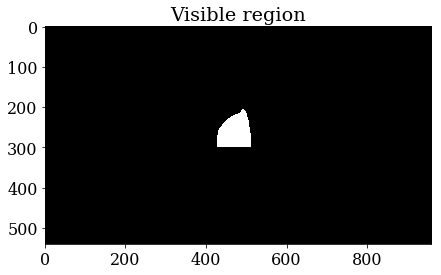

In [9]:
## 1. occlusion
# select center and cut mask
segid = 255
mask_y, mask_x, _ = np.where(left.seg == segid)
cen = np.column_stack([mask_y, mask_x]).mean(0).astype(int)
seg_new = left.seg.copy()
seg_new[cen[0]:, :] = 0  # 1/2
uvm.update_params('mask', seg_new)
plt.imshow(seg_new); plt.title('Visible region'); plt.show()

number of valid points:  17343
Difference of Tmw_estimated and Tmw_true:
 [[-8.48936886e-02  2.36761739e-02  5.80784160e-02 -3.49686828e-01]
 [ 9.80323352e-03 -2.84264793e-02 -9.53945197e-03 -6.07842127e-01]
 [ 2.85554852e-02  1.00381913e-01 -7.58988096e-03  3.15525769e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
L2 norm of difference:  32.510105883147524


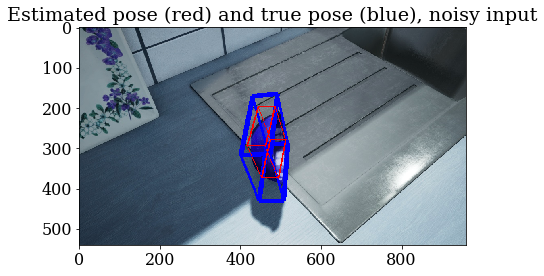

In [10]:
## 2. random select points and mis classify
np.random.seed(0)

rate = 0.05
indexes = [0] + [1 for _ in np.arange(1 // rate)]
keep = np.random.choice(indexes, size=uv_img_perfect.shape)
noise = np.random.randint(0, nbins, size=uv_img_perfect.shape)
img_noise = np.where(keep == 1, uv_img_perfect, noise)

# Draw cuboid (qualitative analysis)
img_disp = uvm.fast_estimate_Tmw_and_compare(img_noise)
plt.imshow(img_disp); plt.title("Estimated pose (red) and true pose (blue), noisy input"); plt.show()

# Extend UV Map with fragments

- Each pixel of object is now represented as (U, V, F)
- F indicates fragment index. E.g. total 8 framents => F in [0, 8)

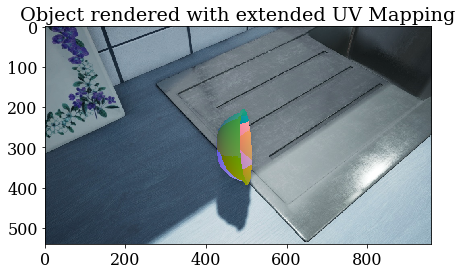

In [11]:
nbins = 256
frag_bins = 8

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

pts_disp = pts[store_dict['depth_sorted_ind'], :]

uvf_img_perfect = uv_map.draw_uvf_map_image(
    pts_disp, pts_ind, scene.left.img, method='s', 
    uv_bins=nbins, frag_bins=frag_bins)
plt.imshow(uvf_img_perfect); 
plt.title("Object rendered with extended UV Mapping"); plt.show()

number of valid points:  36318
Difference of Tmw_estimated and Tmw_true:
 [[ 0.00459167 -0.00125217 -0.0048465  -0.10711483]
 [ 0.00128591 -0.00022771 -0.00142207 -0.02014353]
 [ 0.00084611 -0.00656762  0.0024461   0.12531328]
 [ 0.          0.          0.          0.        ]]
L2 norm of difference:  0.2525716444842776


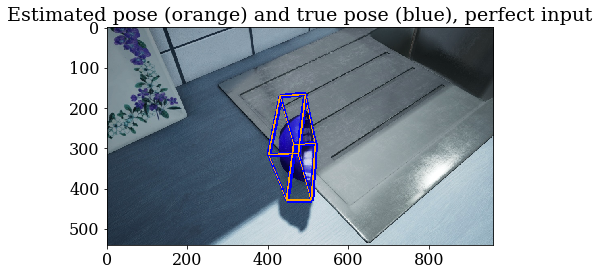

In [13]:
uvf = uv_map.UVFragMapping(
    to_256=True,
    uv_bins=nbins, frag_bins=frag_bins, pnp_method='ransac')
uvf.update_backward_cfg_from_side(left)
_ = uvf._compute_map_to_xyz(pts)

img_disp = uvf.fast_estimate_Tmw_and_compare(
    uvf_img_perfect, color_est='orange')
plt.imshow(img_disp); 
plt.title("Estimated pose (orange) and true pose (blue), perfect input"); plt.show()

number of valid points:  16848
Difference of Tmw_estimated and Tmw_true:
 [[ 2.03078649e-04 -9.62707343e-04 -5.41329486e-03 -1.10358235e-01]
 [-6.81482486e-03 -1.63866568e-03  7.65687426e-03 -1.93651117e-02]
 [-7.60808574e-03 -4.63203701e-03 -5.81804641e-03  5.22728552e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
L2 norm of difference:  0.6524518988284054


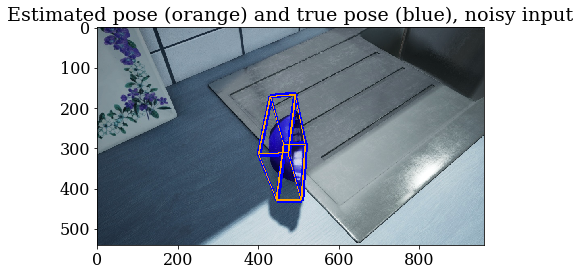

In [14]:
## 1. occlude
# select center and cut mask
segid = 255
mask_y, mask_x, _ = np.where(left.seg == segid)
cen = np.column_stack([mask_y, mask_x]).mean(0).astype(int)
seg_new = left.seg.copy()
seg_new[cen[0]:, :] = 0  # 1/2
# seg_new[:, cen[1]:] = 0  # 1/4
uvf.update_params('mask', seg_new)

## 2. random select points and mis classify
np.random.seed(0)

rate = 0.02
indexes = [0] + [1 for _ in np.arange(1 // rate)]
keep = np.random.choice(indexes, size=uvf_img_perfect.shape)
noise = np.random.randint(0, uvf.uv_bins, size=uvf_img_perfect.shape)
noise[:, :, -1] = np.random.randint(0, uvf.frag_bins, size=uvf_img_perfect.shape[:2])
img_noise = np.where(keep == 1, uvf_img_perfect, noise)

# Draw cuboid (qualitative analysis)
img_disp = uvf.fast_estimate_Tmw_and_compare(
    img_noise, color_est='orange')
plt.imshow(img_disp);
plt.title("Estimated pose (orange) and true pose (blue), noisy input"); plt.show()

# Compare the error curve when increasing miscalssification rate

In [15]:
rates = [0.001] + [0.015*(1+i) for i in range(10)]
uvm.update_params('verbose', False)
uvf.update_params('verbose', False)
img_shape = scene.left.seg.shape

# UV Mapping
np.random.seed(0)
uv_errs = []
for rate in rates:
    indexes = [0] + [1 for _ in np.arange(1 // rate)]
    keep = np.random.choice(indexes, size=img_shape)
    noise = np.random.randint(0, nbins, size=img_shape)
    img_noise = np.where(keep == 1, uv_img_perfect, noise)
    uvf_img_perfect

    # Draw cuboid (qualitative analysis)
    Tmw_est = uvm.fast_estimate_Tmw(img_noise)
    err_norm = np.linalg.norm(left.Tmw_list[0] - Tmw_est, 1)
    uv_errs.append(err_norm)

    
# Extended UV Mapping
np.random.seed(0)
uvf_errs = []
for rate in rates:
    indexes = [0] + [1 for _ in np.arange(1 // rate)]
    keep = np.random.choice(indexes, size=img_shape)
    noise = np.random.randint(0, uvf.uv_bins, size=img_shape)
    noise[:, :, -1] = np.random.randint(0, uvf.frag_bins, size=img_shape[:2])
    img_noise = np.where(keep == 1, uvf_img_perfect,noise)

    Tmw_est = uvf.fast_estimate_Tmw(img_noise)
    err_norm = np.linalg.norm(left.Tmw_list[0] - Tmw_est, 1)
    uvf_errs.append(err_norm)

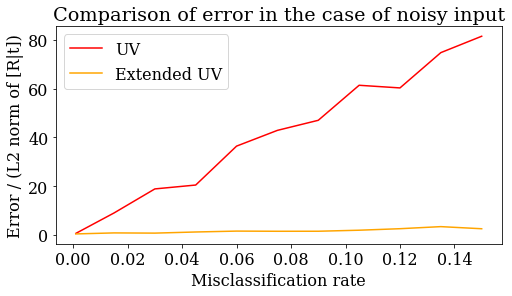

In [16]:
plt.plot(rates, uv_errs, color='red', label='UV')
plt.plot(rates, uvf_errs, color='orange', label='Extended UV')
plt.title('Comparison of error in the case of noisy input')
plt.xlabel('Misclassification rate')
plt.ylabel('Error / (L2 norm of [R|t])')
plt.legend(['UV', 'Extended UV'])
plt.show()